# Гипотеза

Если поискать новые значения n_estimators для learning_rate < 0.01, то могут быть найдены лучшие параметры для повышении скора.

Пока лучшее mean test_score = 0.7161425084850291

> **итог**  
>толку мало... побить лучший текущий скор не удалось...

In [1]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
# Const
RANDOM_STATE = 0
min_rr = 460
max_rr = 963*1.2

print(min_rr, '/', max_rr)

460 / 1155.6


# Полезные методы

In [3]:
def make_XY(df, scaler):
    """
    Подготовка признаков для обучения модели
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    y = df.y.to_numpy()
    X = scaler.transform(df.drop(['y','id','time'], axis=1).to_numpy())

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()
        
        
def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def make_dataset(data):
    """
    Автоматизация подготовки датасета
    """
    df = data.copy()
    ids = df.id.unique()
    for rr_id in ids:
        mask = (df.id==rr_id)
        df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
        df.loc[mask, 'x_diff'] = df[mask].x.diff()
        df.fillna(method='bfill', inplace=True)
        df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
        for i in range(1,5):
            # добавим в признаки 4 следующие точки
            df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
            # и 4 предыдущие точки
            df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
        df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
        df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
        df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
        df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
        df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
        df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
        df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        
    return df

# Данные

In [4]:
with open('../pipelines/dataset-mms-pipeline-2.pkl', 'rb') as f:
    df = pickle.load(f)
with open('../pipelines/scaler-mms-pipeline-2.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
X,y = make_XY(df, scaler)
print(X.shape, y.shape)

train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes] 
y_train = y[train_indexes]
X_test = X[test_indexes]
y_test = y[test_indexes]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60487, 19) (60487,)
(48389, 19) (48389,)
(12098, 19) (12098,)


# Подбор шага обучения и количества деревьев

CPU times: user 26min 41s, sys: 10.6 s, total: 26min 52s
Wall time: 3min 33s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

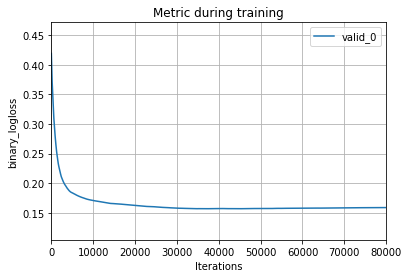

In [7]:
%%time
model = lgb.LGBMClassifier(n_estimators=80000, learning_rate=0.001,
                           random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test,y_test), eval_metric='f1', verbose=False)

lgb.plot_metric(model)

In [8]:
%%time
model = lgb.LGBMClassifier(n_estimators=80000, learning_rate=0.001,
                           random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test,y_test), eval_metric='f1', verbose=False, early_stopping_rounds=100)

print(model.best_iteration_)
print(model.best_score_)
print(model.evals_result_)

23341
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.16047550962753931)])})
{'valid_0': OrderedDict([('binary_logloss', [0.4191471173334231, 0.41885495589081834, 0.4185640357391724, 0.4182743468950875, 0.4179858795037351, 0.4176986238263505, 0.4174125702284283, 0.4171277092339113, 0.4168440314563324, 0.4165615276325173, 0.4162801886322091, 0.41599963763677617, 0.4157202346816772, 0.4154419709399851, 0.41516483770986545, 0.4148888263607951, 0.41461392840084227, 0.4143398550932467, 0.41406687952559534, 0.41379474300684255, 0.41352368847778964, 0.413253707909695, 0.4129847933855872, 0.4127169370562609, 0.41245013117108154, 0.41219016443997936, 0.411925824137622, 0.41166787963176243, 0.41141133361214144, 0.4111557789862921, 0.4108954495619068, 0.41064185603205, 0.4103892328459344, 0.4101375731448299, 0.4098811433455494, 0.409631389837029, 0.4093825796858061, 0.4091347756872997, 0.40888790151749504, 0.4086419507787089, 0.40838968670415715, 0.408

In [11]:
%%time
model = lgb.LGBMClassifier(n_estimators=60000, learning_rate=0.0001,
                           random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test,y_test), eval_metric='f1', verbose=False, early_stopping_rounds=100)

print(model.best_iteration_)
print(model.best_score_)

59999
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.1795103850403715)])})
CPU times: user 25min 22s, sys: 8.38 s, total: 25min 31s
Wall time: 3min 21s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

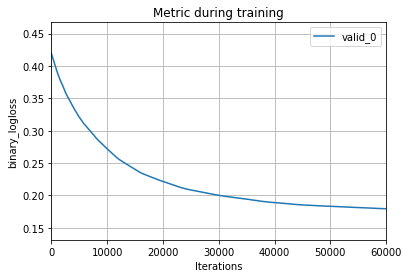

In [12]:
lgb.plot_metric(model)